In [663]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.special import expit, logit

import pymc as pm
import bambi as bmb
import pytensor.tensor as pt
import random

import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
from causalgraphicalmodels import CausalGraphicalModel
import daft

In [664]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.5.3
numpy==1.24.2
arviz==0.15.1
seaborn==0.12.2
pymc==5.1.2
bambi==0.10.0
daft==0.1.2
matplotlib==3.7.1


In [665]:
SEED = 20012808

In [666]:
# import the data prepared in ERF_get_data_prereg

real_data = pd.read_csv(r'C:\Users\u0124323\Dropbox\FWO Project soorten\Papers\Vignette study\VTD_main_df.csv')
df2 = real_data.copy()

# limit to taxonomists
real_data = real_data.loc[real_data['taxonomist?'] == 'taxonomist']

# DAG


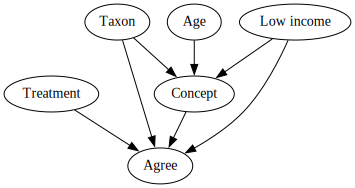

In [668]:
tax_dag_Concept = CausalGraphicalModel(
    nodes=["Species Concept", "Low income",  "Agree", 'Specialization', 'Treatment'], edges=[
        
        ("Species Concept", "Agree"),
        
        ("Low income", "Species Concept"),
        ("Specialization", "Species Concept"),       
        ('Treatment','Agree'),
        ('Specialization','Agree'),
        ('Low income','Agree')
    ]
)


tax_dag_Concept.draw()

Questions for case 3:

- What is the causal effect of SC on split?
- Does treatment effect vary between species concepts? We would expect the difference between 'No gene flow' and 'Gene flow' to be the largest for BSC, and definitely a lot smaller for diaPSC.

In [669]:
def independencies(dag):
    all_independencies = dag.get_all_independence_relationships()
    for s in all_independencies:
        if all(
            t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
            for t in all_independencies
            if t != s
        ):
            print(s)
independencies(tax_dag_Concept)

('Agree', 'Age', {'Low income', 'Concept', 'Taxon'})
('Age', 'Treatment', set())
('Age', 'Taxon', set())
('Age', 'Low income', set())
('Treatment', 'Taxon', set())
('Treatment', 'Concept', set())
('Treatment', 'Low income', set())
('Taxon', 'Low income', set())


In [672]:
# check which variables to include

# function to check open backdoor paths and, hence, which variables to control for

def backdoor(dag, pred, outcome):
    all_adjustment_sets = dag.get_all_backdoor_adjustment_sets(pred, outcome)
    for s in all_adjustment_sets:
        if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
            print(s)

backdoor(tax_dag_Concept,'Species Concept','Agree')

frozenset({'Low income', 'Taxon'})


**In the paper, we report on model 7 below, given that it follows most directly from our DAG. This is the model:**

<u>*Likelihood:*</u>

Agree ~ Bernoulli(p)

*Linear model:*

logit(p<sub>i</sub>) = $\alpha$<sub>gen</sub> + $\alpha$1<sub>sc[i]</sub> + $\alpha$2<sub>tax[i]</sub> + $\alpha$3<sub>cont[i]</sub> + $\beta$_treat<sub>treat[i]</sub> + $\beta$_vartreat<sub>sc[i],treat[i]</sub> 


<u>*Fixed priors:*</u>
    
$\alpha$<sub>gen</sub> ~ Normal(0,1)

$\alpha$1_sigma ~ Uniform(0,5)

$\alpha$2_sigma ~ Uniform(0,5)

$\beta$_vartreat_sigma ~ Uniform(0,5)

$\beta$_treat<sub>treat</sub> ~ Normal(0,1)  
    
$\alpha$3<sub>cont</sub> ~ Normal(0,1)  
  


<u>*Adaptive priors:*</u>

$\alpha$1<sub>sc</sub> ~ Normal(0,$\alpha$1_sigma)

$\alpha$2<sub>tax</sub> ~ Normal(0,$\alpha$2_sigma) 

$\beta$_vartreat<sub>sc,treat</sub> ~ Normal(0,$\beta$_vartreat_sigma) 





# Indices and data

## Real data

In [673]:
df = real_data[['c3_agree','condition_c3','specialization','low_income','species_concepts']].copy()
df.columns = ['agree','t','tax','cont','sc']
df = df.dropna()
df = df[~df.apply(lambda row: row.astype(str).str.contains('No response', case=False).any(), axis=1)]
df = df.astype('category')
df.head()

,agree,t,tax,cont,sc
0,yes,Gene flow,Non-insect Arthropods,0,BSC
1,yes,No gene flow,Insects,0,ESC
2,yes,Neutral,Non-insect Arthropods,0,BSC
3,yes,No gene flow,Plants,0,diaPSC
4,yes,No gene flow,Plants,0,diaPSC


## Simulated data

In [ ]:
## true values

N = 500 #observations

basic = 0.2

# taxon

ntax = 14
bbar2 = 0
sigma3 = 1.5
tax_coef = np.random.normal(bbar2, sigma3, ntax)
tax_prop = real_data.specialization.value_counts(normalize = True).values


# continent

cont_coef = np.array([0,0.8])
cont_prop = np.array([0.4,0.6])
ncont = 2


# tax idx and cont idx

nt = 3
tax_idx = list(np.concatenate([np.repeat(i, np.round(tax_prop *N, 0)[i]) for i in range(ntax)]))
cont_idx = list(np.concatenate([np.repeat(i, np.round(cont_prop *N, 0)[i]) for i in range(ncont)]))
random.shuffle(tax_idx)
random.shuffle(cont_idx)

# make sure they are the same size
a = len(cont_idx) - len(tax_idx)

if a > 0:
    tax_idx.extend(list(np.random.randint(0,2,size = a)))
else:
    tax_idx = tax_idx[:(len(cont_idx) - 1)]



# # scs
alpha, sigma1 = 0, 0.5
nsc = 6
sc_coef = np.random.normal(alpha, sigma1, nsc)
sc_prop = real_data.species_concepts.value_counts(normalize = True).values



## treatments

# neutral vs extra info


t1, t2, t3 = -2, 2, 0
sigma_b1a, sigma_b1b, sigma_b1c = 1, 1, 1

bbar1a_coef = np.random.normal(0, sigma_b1a, nsc)
bbar1b_coef = np.random.normal(0, sigma_b1b, nsc)
bbar1c_coef = np.random.normal(0, sigma_b1c, nsc)


## get sc index

# influence of continent/tax on sc

a = np.random.uniform(0,60,(nsc,ncont)) 
c_sc = a / a.sum()

a = np.random.uniform(0,60,(nsc,ntax)) 
t_sc = a / a.sum()


sc_idx = []

for i in range(len(tax_idx)):
    tax = tax_idx[i]
    cont = cont_idx[i]
    zero = t_sc[0,tax]+ c_sc[0,cont]
    one = t_sc[1,tax]+c_sc[1,cont]
    two = t_sc[2,tax]+c_sc[2,cont]
    three = t_sc[3,tax]+c_sc[3,cont]
    four = t_sc[4,tax]+c_sc[4,cont]
    five = t_sc[5,tax]+c_sc[5,cont]
    
    val = np.random.choice(
    a = [0,1,2,3,4,5],
    size = 1,
    p = [zero,one,two,three,four,five] / np.sum([zero,one,two,three,four,five])
    )
    sc_idx.append(val[0])

## Treatment indenx

t_idx = list(np.tile([0,1,2], len(sc_idx) // 3))

a = len(sc_idx) - len(t_idx)

if a > 0:
    t_idx.extend(list(np.random.randint(0,2,size = a)))


## combine everything in a df
df = pd.DataFrame(dict(sc = sc_idx, t = t_idx, cont = cont_idx, tax = tax_idx))



## bernoulli trials
# run a bernoulli trial for each row using all coefficients


agree = []


for i in range(len(df)):
    if df.t.iloc[i] == 0:
        a = np.random.binomial(1, expit(basic + cont_coef[df.cont.iloc[i]] + sc_coef[df.sc.iloc[i]] + t1 + bbar1a_coef[df.sc.iloc[i]]))
        agree.append(a)
    elif df.t.iloc[i] == 1:
        a = np.random.binomial(1, expit(basic+ cont_coef[df.cont.iloc[i]] + sc_coef[df.sc.iloc[i]] + t2 + bbar1b_coef[df.sc.iloc[i]]))
        agree.append(a)
    else:
        a = a = np.random.binomial(1, expit(basic+ cont_coef[df.cont.iloc[i]] + sc_coef[df.sc.iloc[i]] + t3 + bbar1c_coef[df.sc.iloc[i]]))
        agree.append(a)
        
df['agree'] = agree

# store real values in a dct

all_coef = {'basic':basic, 'scbar':alpha,'scsigma': sigma1, 'info':info,'t1':t1,'t2':t2,'sigmat1':sigma_b1a,
            'sigmat2':sigma_b1b, 't1coef': bbar1a_coef, 't2coef':bbar1b_coef, 'ccoef':cont_coef[1],
            'tax_coef':tax_coef,'tax_sigma':sigma3, 'sc_coef':sc_coef}


# change dtype for the models
df = df.astype('category')

df.head()



## coordinates for the models

In [675]:
#  Index of positions
t_idx = df.t.cat.codes.values
sc_idx = df.sc.cat.codes.values
agree_idx = df.agree.cat.codes.values
tax_idx = df.tax.cat.codes.values
cont_idx = df.cont.cat.codes.values



# The 9 position names
t_codes = df.t.cat.categories.values
sc_codes = df.sc.cat.categories.values
tax_codes = df.tax.cat.categories.values
cont_codes = df.cont.cat.categories.values



coords = {'t_n': t_codes,  'sc_n':sc_codes, 'tax_n':tax_codes, 'c_n':cont_codes, 'agree_codes':agree_idx}

# Model 1: SC --> Agree

In [676]:
with pm.Model(coords = coords) as m1:
    
    # Data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    
    # sc intercept
    a_sc = pm.Normal('a_sc',0,1,dims = 'sc_n')
    
    # intercept
    a = pm.Normal('a',0,1)
    
    # linear model
    p = pm.math.invlogit(a + a_sc[S])
    
    agree = pm.Bernoulli('agree',p=p, observed = df.agree.cat.codes.values)
    
    tracem1 = pm.sample(10000,idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_sc, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 60 seconds.


In [677]:
az.summary(tracem1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_sc[BSC],0.625,0.447,-0.204,1.476,0.004,0.003,10127.0,15700.0,1.0
a_sc[ESC],0.085,0.438,-0.719,0.929,0.004,0.003,9877.0,14971.0,1.0
a_sc[GCSC],0.312,0.625,-0.869,1.479,0.005,0.003,18204.0,23841.0,1.0
a_sc[diaPSC],0.322,0.437,-0.481,1.157,0.004,0.003,9689.0,14191.0,1.0
a_sc[monoPSC],-0.105,0.477,-1.016,0.783,0.004,0.003,11643.0,17498.0,1.0
a_sc[other],-0.564,0.472,-1.447,0.328,0.004,0.003,11125.0,17029.0,1.0
a,0.717,0.401,-0.033,1.475,0.004,0.003,8470.0,11915.0,1.0


# Model 2: Add treatment

In [678]:
with pm.Model(coords = coords) as m2:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    
    # fixed priors
    a_sc = pm.Normal('a_sc',0,1,dims = 'sc_n')
    t = pm.Normal('t',0,1,dims = 't_n')
    a = pm.Normal('a',0,1)
    
    # linear model
    p = pm.math.invlogit(a + a_sc[S] + t[T])
    
    agree = pm.Bernoulli('agree',p=p, observed = df.agree.cat.codes.values)
    
    tracem2 = pm.sample(10000,idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_sc, t, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 74 seconds.


In [679]:
az.summary(tracem2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_sc[BSC],0.618,0.450,-0.202,1.493,0.004,0.003,13310.0,20477.0,1.0
a_sc[ESC],0.065,0.442,-0.761,0.893,0.004,0.003,13123.0,19751.0,1.0
a_sc[GCSC],0.276,0.630,-0.898,1.466,0.004,0.003,21342.0,24377.0,1.0
a_sc[diaPSC],0.300,0.439,-0.524,1.126,0.004,0.003,13145.0,19149.0,1.0
a_sc[monoPSC],-0.158,0.481,-1.078,0.738,0.004,0.003,14402.0,20743.0,1.0
a_sc[other],-0.545,0.474,-1.420,0.358,0.004,0.003,14638.0,21080.0,1.0
t[Gene flow],0.041,0.535,-0.978,1.036,0.005,0.003,13413.0,18450.0,1.0
t[Neutral],0.094,0.534,-0.915,1.098,0.005,0.003,13334.0,18198.0,1.0
t[No gene flow],0.453,0.537,-0.580,1.441,0.005,0.003,13490.0,18669.0,1.0
a,0.554,0.581,-0.573,1.617,0.005,0.004,12297.0,16994.0,1.0


# Model 3: Add controls for tax and cont

In [680]:
with pm.Model(coords=coords) as m3:
    
    # Data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    TA = pm.MutableData('TA', df.tax.cat.codes.values)
    C = pm.MutableData('C', df.cont.cat.codes.values)
    
    # fixed priors for intecept, sc, tax and income
    a = pm.Normal('a',0,1)
    a_sc = pm.Normal('a_sc',0,1,dims = 'sc_n')
    b1 = pm.Normal('b1',0,1,dims = 't_n')
    b2 = pm.Normal('b2',0,1,dims = 'tax_n')
    b3 = pm.Normal('b3',0,1)
    
    p = a + a_sc[S] + b1[T] + b2[TA] + b3*C
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    pr3 = pm.sample_prior_predictive()               

Sampling: [a, a_sc, agree, b1, b2, b3]


In [681]:
with m3:
    tracem3 = pm.sample(10000,idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, a_sc, b1, b2, b3]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 92 seconds.


In [682]:
az.summary(tracem3).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.436,0.623,-0.695,1.644,0.005,0.004,13214.0,20448.0,1.0
a_sc[BSC],0.526,0.458,-0.359,1.358,0.004,0.003,13943.0,23047.0,1.0
a_sc[ESC],0.101,0.446,-0.755,0.913,0.004,0.003,13583.0,21772.0,1.0
a_sc[GCSC],0.225,0.636,-0.963,1.426,0.004,0.003,26031.0,27946.0,1.0
a_sc[diaPSC],0.246,0.448,-0.589,1.080,0.004,0.003,13482.0,21867.0,1.0


# multilevel models

## Model 4: only sc

In [683]:
with pm.Model(coords=coords) as m4:
    
    S = pm.MutableData('S', df.sc.cat.codes.values)
    
    # fixed priors
    a_gen = pm.Normal('a_gen',0,1)
    a1_sigma = pm.Uniform('a1_sigma',0,5)
    
    # adaptive priors
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    a1 = pm.Deterministic("a1",z1*a1_sigma)
    
    p = (a_gen + a1[S])
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr4 = pm.sample_prior_predictive()


Sampling: [a1_sigma, a_gen, agree, z1]


In [684]:
with m4:
    tracem4 = pm.sample(10000, tune = 3000, target_accept = 0.95, idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_gen, a1_sigma, z1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 75 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [685]:
az.summary(trace4).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_gen,0.301,0.208,-0.090,0.695,0.005,0.003,2172.0,2341.0,1.0
z1[0],0.932,0.598,-0.164,2.049,0.010,0.007,3646.0,4840.0,1.0
z1[1],0.019,0.594,-1.144,1.120,0.009,0.007,4077.0,5135.0,1.0
z1[2],-0.320,0.603,-1.488,0.801,0.009,0.007,4280.0,5364.0,1.0
z1[3],1.288,0.619,0.141,2.453,0.010,0.007,3501.0,4321.0,1.0


## Model 5: Treatment (varying by sc) + sc

In [686]:
with pm.Model(coords=coords) as m5:
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    
    # fixed priors
    a_gen = pm.Normal('a_gen',0,1)
    a1_sigma = pm.Uniform('a1_sigma',0,5)
    b_t = pm.Normal('b_t',0,2, dims = 't_n')
    b_st_sigma = pm.Uniform('b_st_sigma',0,5)
    
    # adaptive priors (non centered)
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    z3 = pm.Normal('z3',0,1, dims = ('sc_n','t_n'))
    a1 = pm.Deterministic("a1",z1*a1_sigma)
    b_st = pm.Deterministic("b_st", z3*b_st_sigma)
    
    p = (a_gen + a1[S]  + b_t[T] + b_st[S,T])
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr5 = pm.sample_prior_predictive()

Sampling: [a1_sigma, a_gen, agree, b_st_sigma, b_t, z1, z3]


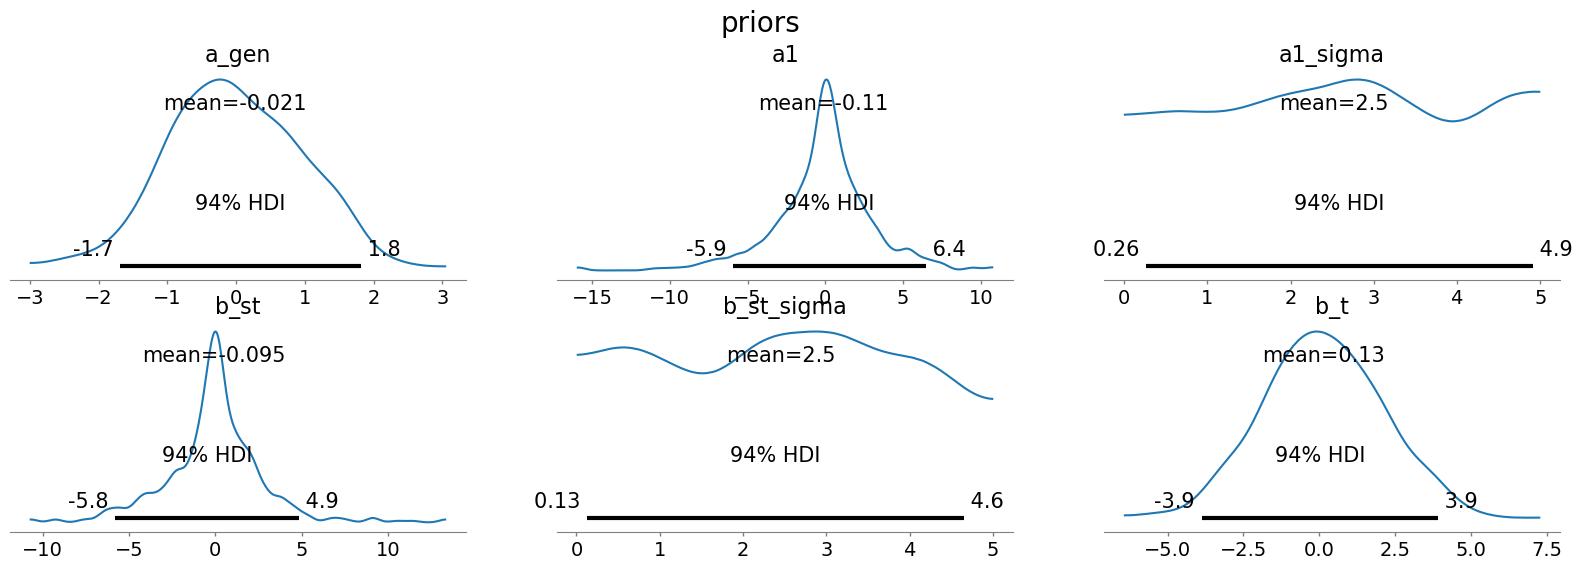

In [687]:
#a1, b1, b2, b3, abbar, bbar, sigma, Rho_corr

fig, axs = plt.subplots(2,3, figsize = (20,6))

for ax, para in zip(axs.flat, ['a_gen', 'a1','a1_sigma','b_st','b_st_sigma','b_t']):
    if len(pr.prior[para].shape) == 3:
        az.plot_posterior(pr.prior[para][:,:,0], ax=ax)
    elif len(pr.prior[para].shape) == 2:
        az.plot_posterior(pr.prior[para],ax=ax)
    else:
        az.plot_posterior(pr.prior[para][:,:,1,0],ax=ax)
plt.suptitle('priors', fontsize = 20) 

plt.show()
fig.tight_layout()

In [688]:
with m5: 
    tracem5 = pm.sample(10000, tune = 3000,idata_kwargs={"log_likelihood": True}, target_accept = 0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_gen, a1_sigma, b_t, b_st_sigma, z1, z3]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 268 seconds.


In [689]:
az.summary(tracem5).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_gen,0.358,0.769,-1.080,1.792,0.006,0.004,17571.0,21488.0,1.0
b_t[Gene flow],0.377,0.806,-1.164,1.876,0.006,0.004,17083.0,22411.0,1.0
b_t[Neutral],0.304,0.804,-1.176,1.833,0.006,0.004,17000.0,21843.0,1.0
b_t[No gene flow],0.777,0.808,-0.703,2.344,0.006,0.004,17165.0,21756.0,1.0
z1[BSC],0.687,0.784,-0.743,2.240,0.005,0.003,25896.0,21631.0,1.0


## Model 6: add continent

In [690]:
with pm.Model(coords=coords) as m6:
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    C = pm.MutableData('C',df.cont.cat.codes.values)
    
    ## fixed priors
    a_gen = pm.Normal('a_gen',0,1) # intercept
    a1_sigma = pm.Uniform('a1_sigma',0,5) # hyperprior variance sc
    b_t = pm.Normal('b_t',0,2, dims = 't_n') # treatment parameter
    b_st_sigma = pm.Uniform('b_st_sigma',0,5) # hyperprior varying effects treatment/sc
    a_cont = pm.Normal('a_cont',0,1) # income parameter

    
    # adaptive priors (non centered)
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    z3 = pm.Normal('z3',0,1, dims = ('sc_n','t_n'))
    a1 = pm.Deterministic("a1",z1*a1_sigma)
    b_st = pm.Deterministic("b_st", z3*b_st_sigma)
    
    p = (a_gen + a1[S]  + b_t[T] + b_st[S,T] + a_cont * C)
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr6 = pm.sample_prior_predictive()

Sampling: [a1_sigma, a_cont, a_gen, agree, b_st_sigma, b_t, z1, z3]


In [691]:
with m6: 
    tracem6 = pm.sample(10000, tune = 3000, target_accept = 0.95,idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_gen, a1_sigma, b_t, b_st_sigma, a_cont, z1, z3]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 264 seconds.


In [692]:
az.summary(tracem6).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_gen,0.319,0.768,-1.139,1.738,0.006,0.004,16023.0,21712.0,1.0
b_t[Gene flow],0.319,0.807,-1.155,1.875,0.006,0.005,15542.0,21388.0,1.0
b_t[Neutral],0.259,0.806,-1.241,1.793,0.006,0.005,15726.0,21443.0,1.0
b_t[No gene flow],0.735,0.809,-0.754,2.285,0.007,0.005,15468.0,21131.0,1.0
a_cont,0.323,0.238,-0.113,0.782,0.001,0.001,44707.0,29943.0,1.0


## Model 7: Add taxon

<u>*Likelihood:*</u>

Agree ~ Bernoulli(p)

*Linear model:*

logit(p<sub>i</sub>) = $\alpha$<sub>gen</sub> + $\alpha$1<sub>sc[i]</sub> + $\alpha$2<sub>tax[i]</sub> + $\alpha$3<sub>cont[i]</sub> + $\beta$_treat<sub>treat[i]</sub> + $\beta$_vartreat<sub>sc[i],treat[i]</sub> 


<u>*Fixed priors:*</u>
    
$\alpha$<sub>gen</sub> ~ Normal(0,1)

$\alpha$1_sigma ~ Uniform(0,5)

$\alpha$2_sigma ~ Uniform(0,5)

$\beta$_vartreat_sigma ~ Uniform(0,5)

$\beta$_treat<sub>treat</sub> ~ Normal(0,1)  
    
$\alpha$3<sub>cont</sub> ~ Normal(0,1)  
  


<u>*Adaptive priors:*</u>

$\alpha$1<sub>sc</sub> ~ Normal(0,$\alpha$1_sigma)

$\alpha$2<sub>tax</sub> ~ Normal(0,$\alpha$2_sigma) 

$\beta$_vartreat<sub>sc,treat</sub> ~ Normal(0,$\beta$_vartreat_sigma) 



In [708]:
with pm.Model(coords=coords) as m7:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    C = pm.MutableData('C',df.cont.cat.codes.values)
    TA = pm.MutableData('TA',df.tax.cat.codes.values)
    
    # fixed priors
    a_gen = pm.Normal('a_gen',0,1)
    a1_sigma = pm.Uniform('a1_sigma',0,5) # sc hyperprior
    b_treat = pm.Normal('b_treat',0,2, dims = 't_n')
    b_vartreat_sigma = pm.Uniform('b_vartreat_sigma',0,5) # varying effects hyperprior
    a3 = pm.Normal('a3',0,1, dims = 'c_n')
    a2_sigma = pm.Uniform('a2_sigma',0,5) # specialization hyperprior

    
    # adaptive priors (non centered)
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    z2 = pm.Normal('z2',0,1, dims = 'tax_n')
    z3 = pm.Normal('z3',0,1, dims = ('sc_n','t_n'))
    a1 = pm.Deterministic("a1",z1*a1_sigma, dims = 'sc_n')
    a2 = pm.Deterministic("a2",z2*a2_sigma, dims = 'tax_n')
    b_vartreat = pm.Deterministic("b_vartreat", z3*b_vartreat_sigma, dims = ('sc_n','t_n'))
    
    p = (a_gen + a1[S] + a2[TA] + a3[C] + b_treat[T] + b_vartreat[S,T])
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr7 = pm.sample_prior_predictive()

Sampling: [a1_sigma, a2_sigma, a3, a_gen, agree, b_treat, b_vartreat_sigma, z1, z2, z3]


In [709]:
with m7: 
    tracem7 = pm.sample(10000, tune = 3000, target_accept = 0.95,idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_gen, a1_sigma, b_treat, b_vartreat_sigma, a3, a2_sigma, z1, z2, z3]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 403 seconds.


In [710]:
az.summary(tracem7).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_gen,0.300,0.813,-1.266,1.791,0.004,0.004,37408.0,29176.0,1.0
b_treat[Gene flow],0.265,0.879,-1.362,1.922,0.006,0.004,24601.0,27978.0,1.0
b_treat[Neutral],0.227,0.879,-1.356,1.936,0.006,0.004,24620.0,28031.0,1.0
b_treat[No gene flow],0.721,0.879,-0.903,2.389,0.006,0.004,24541.0,27608.0,1.0
a3[0],-0.009,0.654,-1.246,1.207,0.003,0.003,36769.0,28809.0,1.0


# Compare models

Note that this just checks the in and out of sample fit of the models -- no causal conclusions can be drawn from this. Variables to include in the models and the model the report in the paper were chosen on the basis of the DAG and our understanding/assumptions of/about the topic.

In [711]:
models = {'m1':tracem1, 'm2':tracem2,'m3':tracem3,'m4':tracem4, 'm5':tracem5,'m6':tracem6,'m7':tracem7}

a = az.compare(models)
a

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m4,0,-252.962941,4.832903,0.000000,0.507396,8.560903,0.000000,False,log
m1,1,-253.017131,5.608078,0.054191,0.000000,8.892982,1.027860,False,log
m3,2,-253.398945,17.624867,0.436004,0.492604,9.928306,4.404950,False,log
m7,3,-253.648314,17.104099,0.685373,0.000000,9.312879,3.347438,False,log
m2,4,-253.652353,7.576013,0.689412,0.000000,9.045679,1.897538,False,log
m5,5,-253.685493,10.583423,0.722552,0.000000,8.937241,2.157807,False,log
m6,6,-253.796975,11.417866,0.834035,0.000000,9.045860,2.529409,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

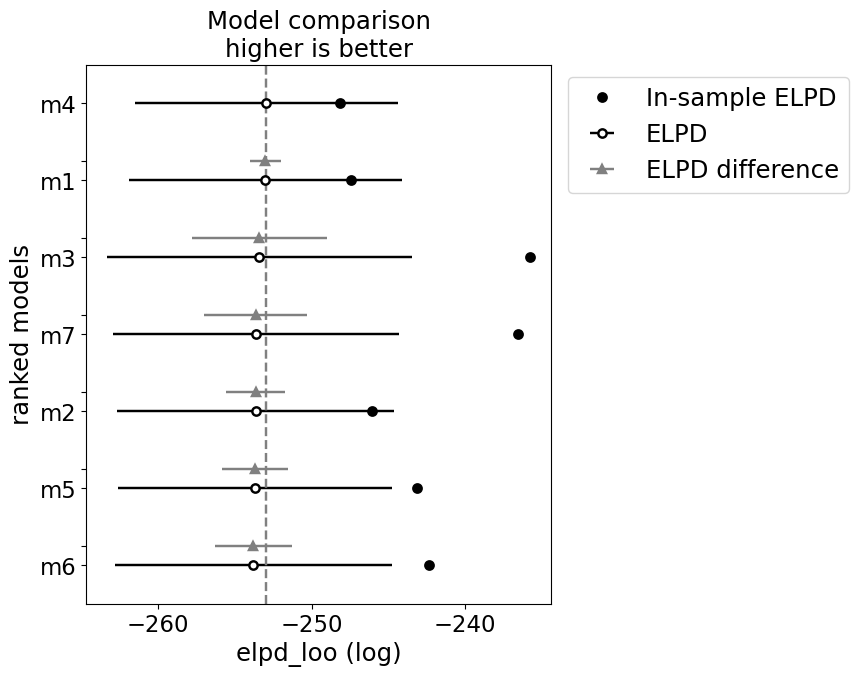

In [712]:
az.plot_compare(a, insample_dev = True)

# Results and interpretation

## General

In [735]:
az.summary(tracem7, var_names = ['a_gen','a1','b_treat','b_vartreat'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_gen,0.300,0.813,-1.266,1.791,0.004,0.004,37408.0,29176.0,1.0
a1[BSC],0.275,0.352,-0.282,1.001,0.002,0.001,28349.0,33795.0,1.0
a1[ESC],0.003,0.305,-0.580,0.628,0.001,0.001,50677.0,33895.0,1.0
a1[GCSC],0.078,0.394,-0.650,0.900,0.002,0.002,58384.0,34134.0,1.0
a1[diaPSC],0.119,0.312,-0.445,0.750,0.002,0.001,43266.0,32668.0,1.0
a1[monoPSC],-0.094,0.337,-0.788,0.527,0.002,0.001,47292.0,34535.0,1.0
a1[other],-0.309,0.376,-1.069,0.272,0.002,0.002,28105.0,33719.0,1.0
b_treat[Gene flow],0.265,0.879,-1.362,1.922,0.006,0.004,24601.0,27978.0,1.0
b_treat[Neutral],0.227,0.879,-1.356,1.936,0.006,0.004,24620.0,28031.0,1.0
b_treat[No gene flow],0.721,0.879,-0.903,2.389,0.006,0.004,24541.0,27608.0,1.0


<Axes: title={'center': 'a_gen'}>

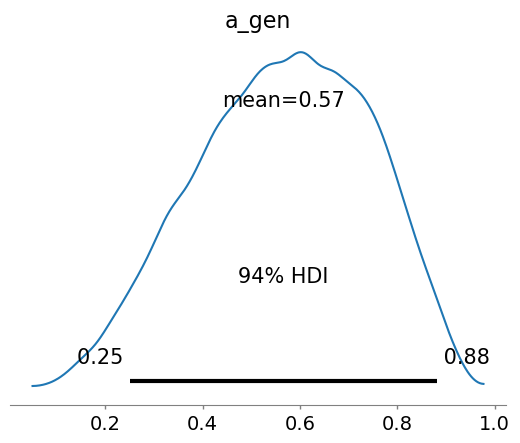

In [713]:
# overall expected proportion, independently from other variables

az.plot_posterior(expit(tracem7.posterior['a_gen']))

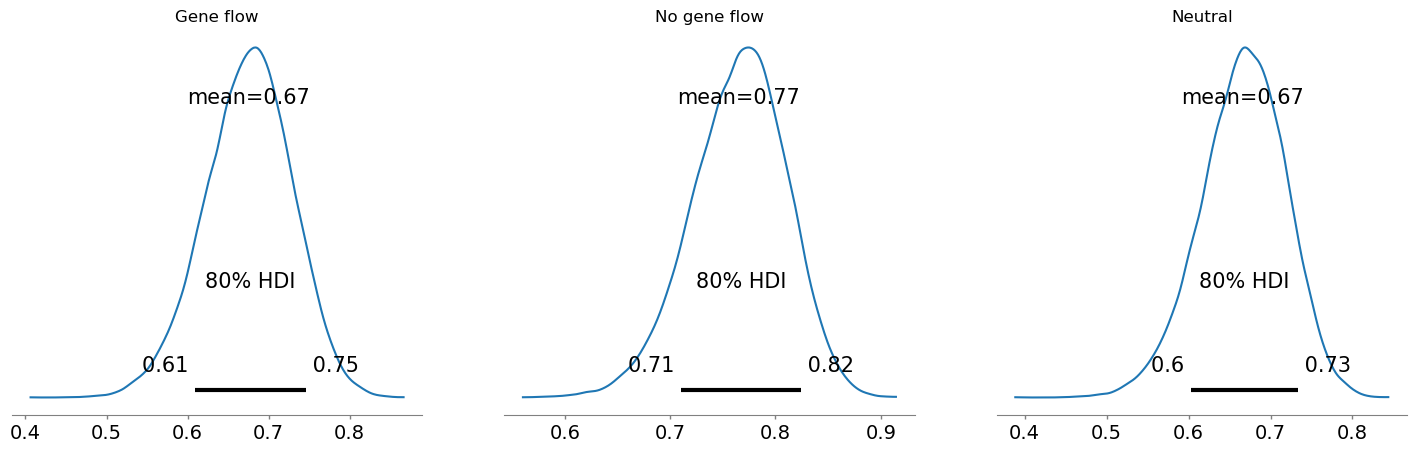

In [714]:
# marginal at the mean of the treatments

fig, axs = plt.subplots(ncols = 3, figsize = (18,5))

for ax,i in zip(axs.flat, ['Gene flow','No gene flow','Neutral']):
    a = (tracem7.posterior['a_gen'] + 
        tracem7.posterior['a1'].mean(dim = 'sc_n')+
        tracem7.posterior['b_treat'].loc[:,:,i] +
        (tracem7.posterior['a3'].mean(dim = 'c_n')) +
        tracem7.posterior['a2'].mean(dim = 'tax_n')+
        tracem7.posterior['b_vartreat'].loc[:,:,:,i].mean(dim = 'sc_n'))
    az.plot_posterior(expit(a), hdi_prob = 0.8,ax=ax)
    ax.set_title(i)


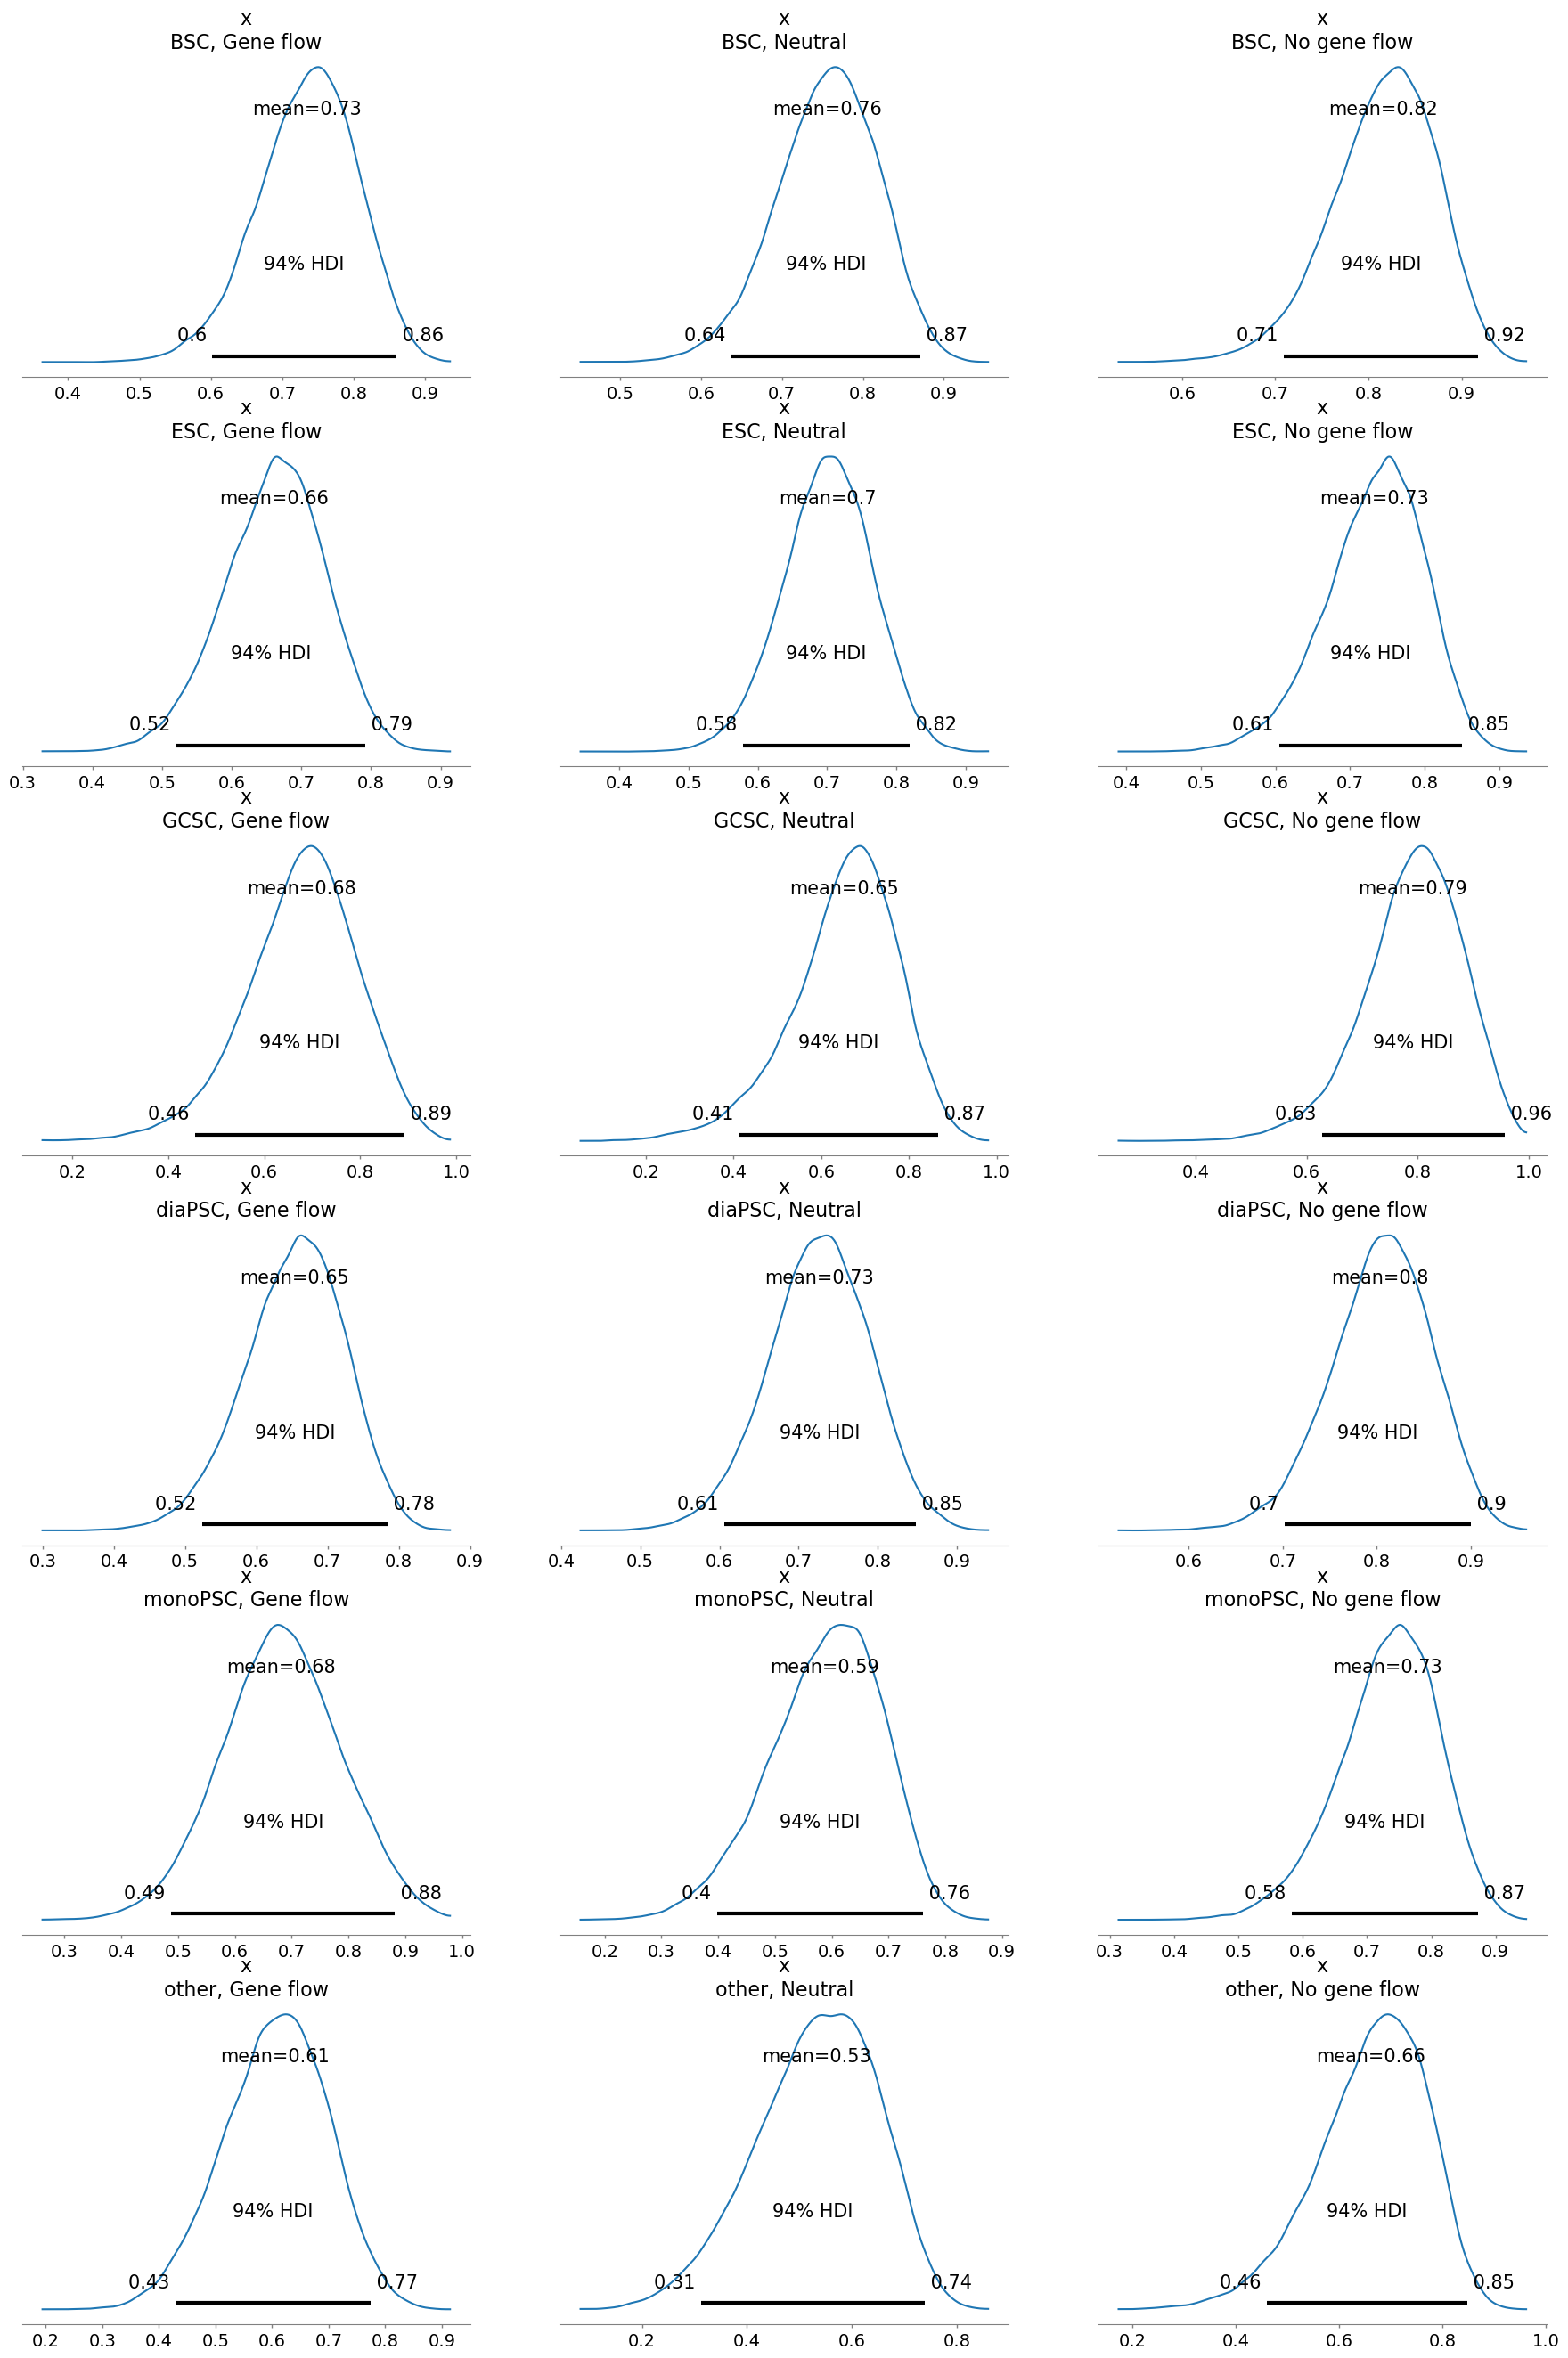

In [715]:
# marginal at the mean of species concept by treatment

a = (tracem7.posterior['a_gen'] + 
        tracem7.posterior['a1']+
        tracem7.posterior['b_treat'] +
        (tracem7.posterior['a3'].mean(dim = 'c_n')) +
        tracem7.posterior['a2'].mean(dim = 'tax_n')+
        tracem7.posterior['b_vartreat'])
az.plot_posterior(expit(a))

plt.show()

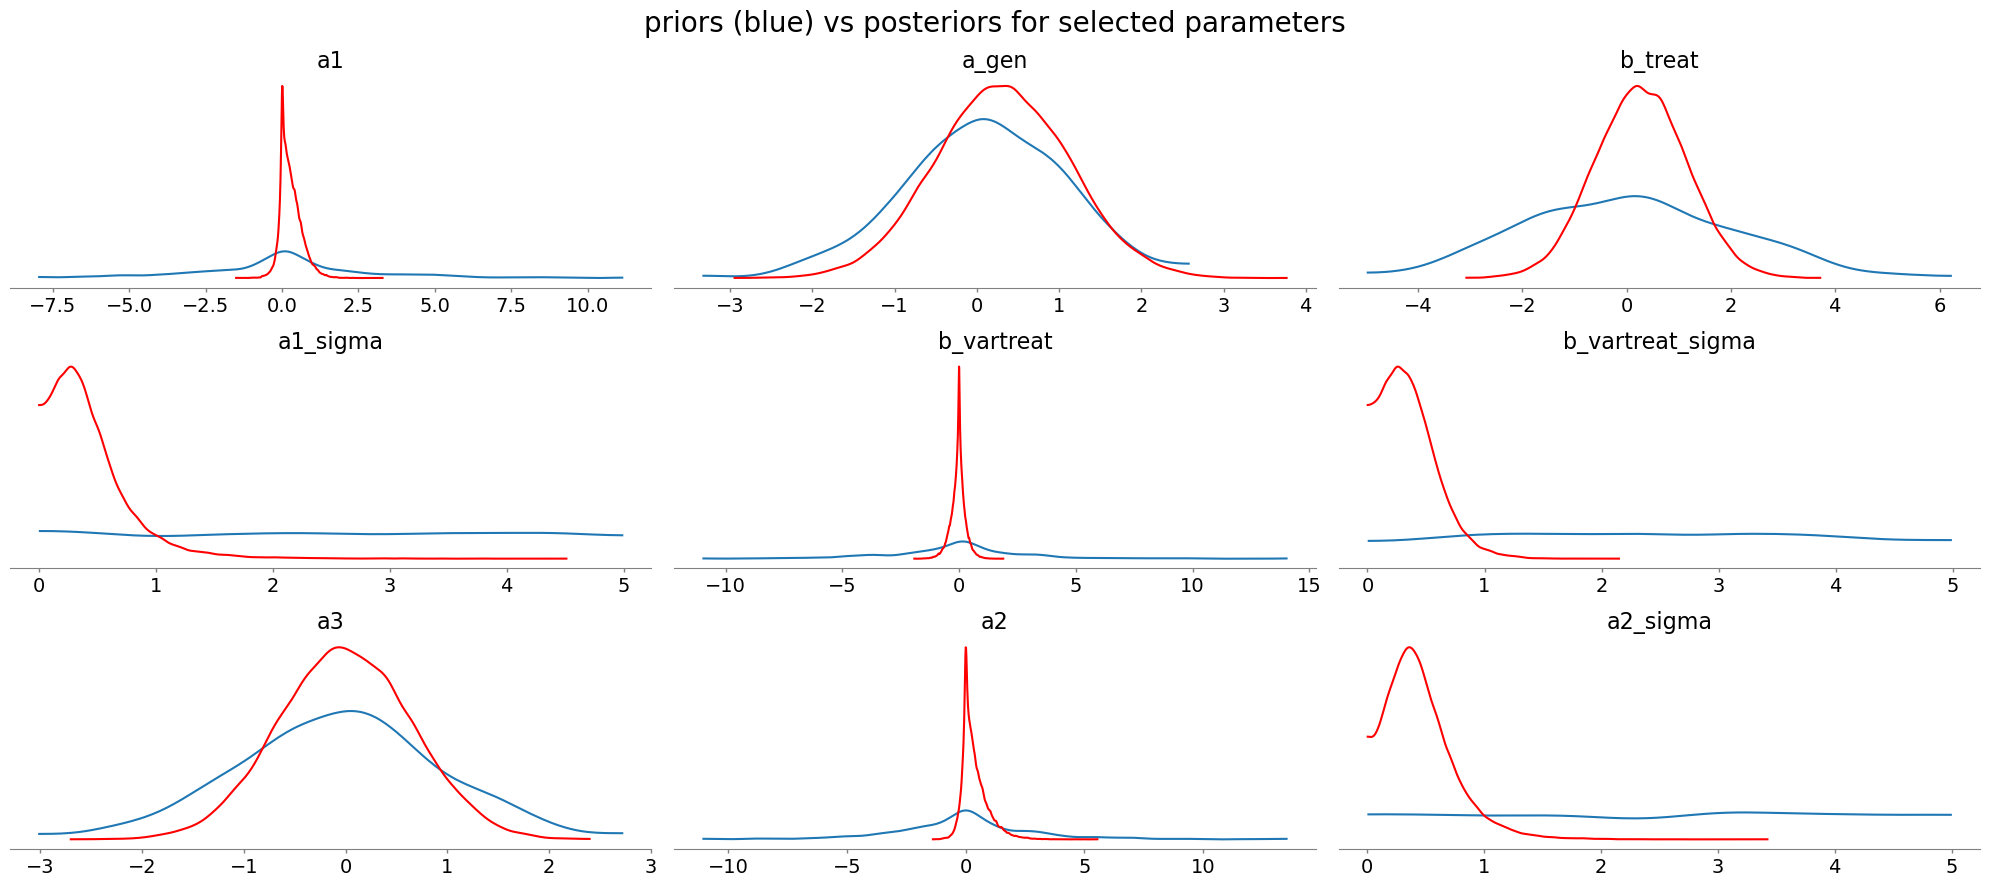

In [716]:
# selected priors vs posteriors -- check if they moved
fig, axs = plt.subplots(3,3, figsize = (20,9))

for ax, para in zip(axs.flat, ['a1','a_gen','b_treat','a1_sigma','b_vartreat','b_vartreat_sigma','a3', 'a2', 'a2_sigma']):
    if len(pr7.prior[para].shape) == 3:
        az.plot_posterior(pr7.prior[para][:,:,0], hdi_prob = 'hide',point_estimate = None, ax=ax)
        az.plot_posterior(tracem7.posterior[para][:,:,0], point_estimate = None,hdi_prob = 'hide', color = 'red', ax=ax)
    elif len(pr7.prior[para].shape) == 2:
        az.plot_posterior(pr7.prior[para], hdi_prob = 'hide',point_estimate = None,ax=ax)
        az.plot_posterior(tracem7.posterior[para],hdi_prob ='hide', point_estimate = None,color = 'red',ax=ax)
    else:
        az.plot_posterior(pr7.prior[para][:,:,1,0], hdi_prob = 'hide',point_estimate = None,ax=ax)
        az.plot_posterior(tracem7.posterior[para][:,:,1,0], hdi_prob = 'hide',point_estimate = None,color = 'red',ax=ax)
        
plt.suptitle('priors (blue) vs posteriors for selected parameters', fontsize = 20) 

fig.tight_layout()

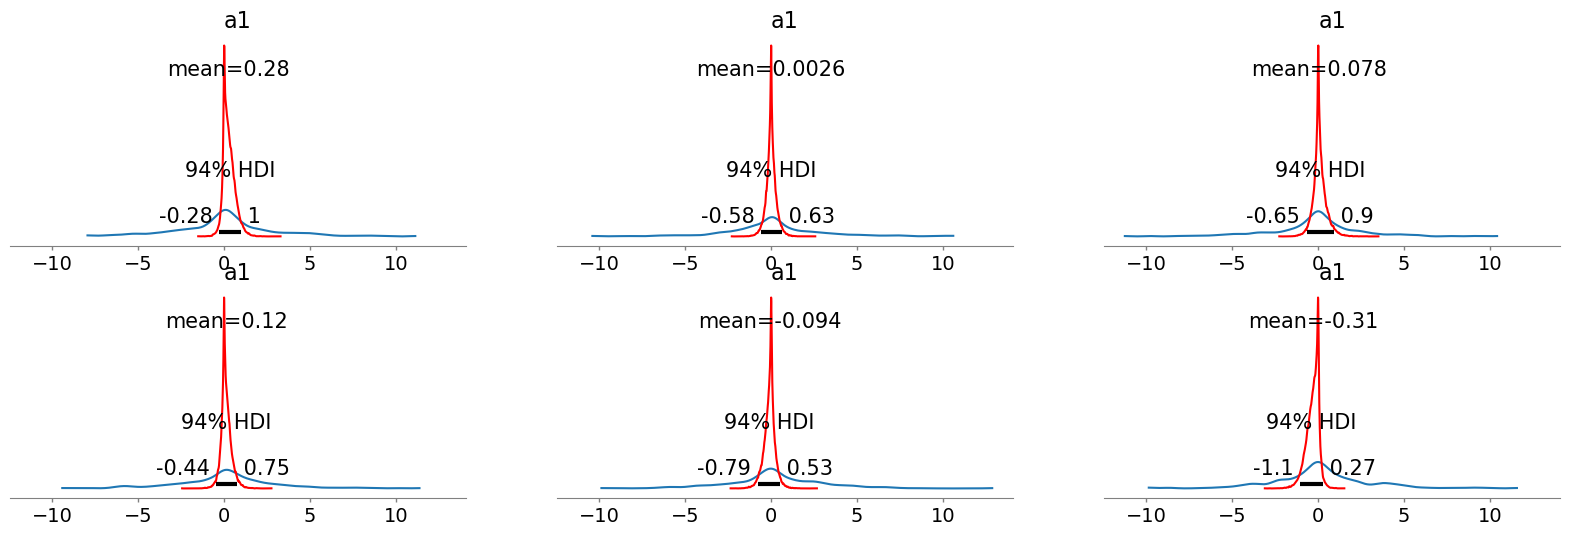

In [717]:
# prior vs posterior for the species concepts


fig, axs = plt.subplots(2,3, figsize = (20,6), sharex = True)

for ax, i in zip(axs.flat, range(6)):
    az.plot_posterior(pr7.prior['a1'][:,:,i], point_estimate = None, hdi_prob = 'hide',ax=ax)
    az.plot_posterior(tracem7.posterior['a1'][:,:,i], color = 'red',ax=ax)

## Causal effect of SC on 'Agree'

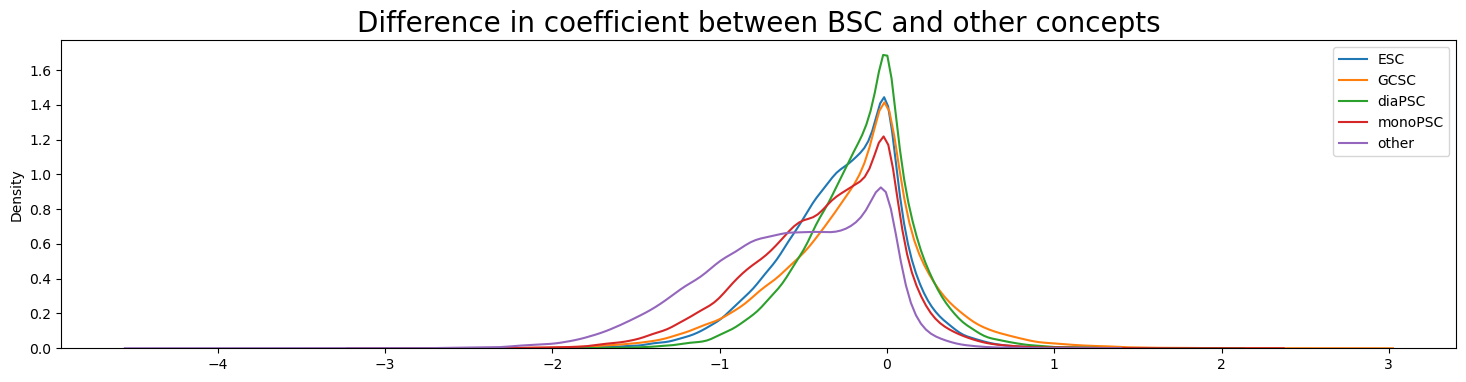

In [718]:
# plot difference in coefficients

fig, ax = plt.subplots(figsize = (18,4))
BSC_result = tracem7.posterior['a1'].loc[:,:,'BSC']

difs = []
for i in tracem7.posterior['sc_n'].values[1:]:
    sns.kdeplot(np.ravel(tracem7.posterior['a1'].loc[:,:,i] - BSC_result),  ax=ax)
    
ax.set_title('Difference in coefficient between BSC and other concepts', fontsize = 20)
ax.legend(list(tracem7.posterior['sc_n'].values[1:]))
plt.show()

Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


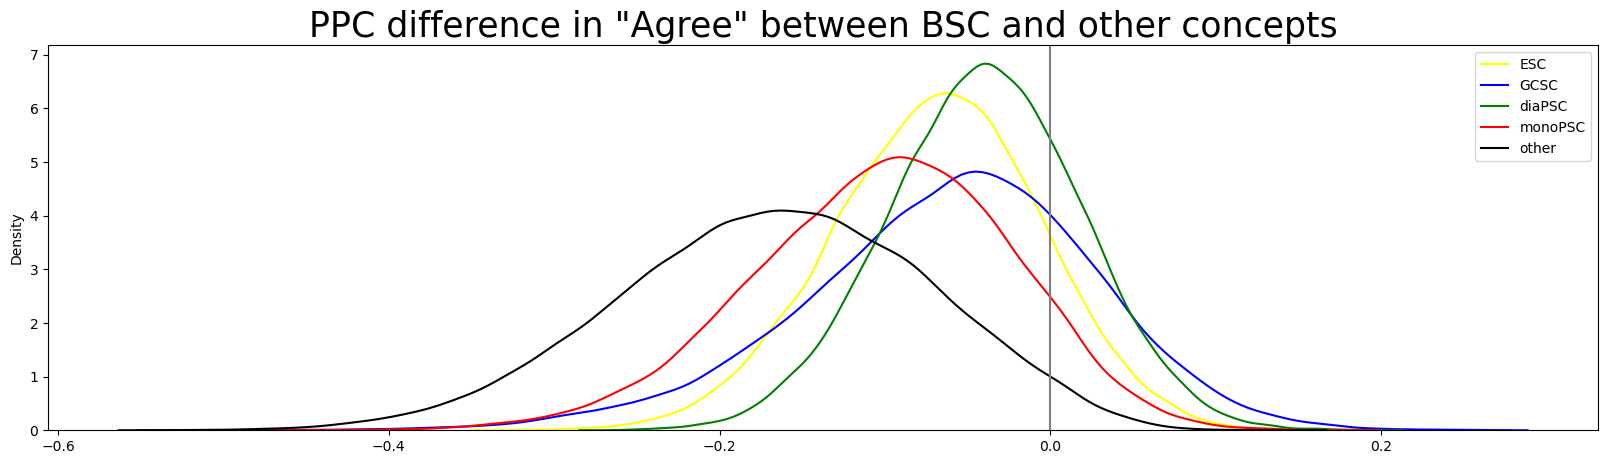

In [719]:
# posterior predictive: resample with full sample subscribing to each of the concepts, and compare resulting agree

# create new data for SC

new_sc_data = {f'sc{i}': np.repeat(i, len(df)) for i in range(6)}

# sample 6x ppc setting full sample for one concept in turn

ppcs = {}
with m7:
    for i in list(range((6))):
        pm.set_data({"S":new_sc_data[f'sc{i}']})
        ppc = pm.sample_posterior_predictive(tracem7, progressbar = False)
        ppcs[f'sc{i}'] = ppc

# plot differences between BSC and the rest

colors = ['EMPTY','yellow','blue','green','red','black']
BSC = az.extract(ppcs[f'sc{0}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

fig, ax = plt.subplots(figsize = (20,5))

for i in range(1,6,1):
    agree_prop = az.extract(ppcs[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    sns.kdeplot(np.array(agree_prop - BSC), color = colors[i],ax=ax )
                    
ax.set_title('PPC difference in "Agree" between BSC and other concepts', fontsize = 25)
ax.legend(['ESC', 'GCSC', 'diaPSC', 'monoPSC', 'other'])
ax.axvline(0, color = 'grey')

plt.show()

## Does treatment effect vary between species concepts?

In [720]:
# check observed data

pd.crosstab(df['sc'], [df['t'], df.agree])

t       Gene flow     Neutral     No gene flow    
agree          no yes      no yes           no yes
sc                                                
BSC             8  24       8  32            5  26
ESC            10  19      11  30           11  22
GCSC            1   2       2   2            0   5
diaPSC         16  26       8  28            7  34
monoPSC         1   7       9   8            5  12
other           8  13       8   4            4   5

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

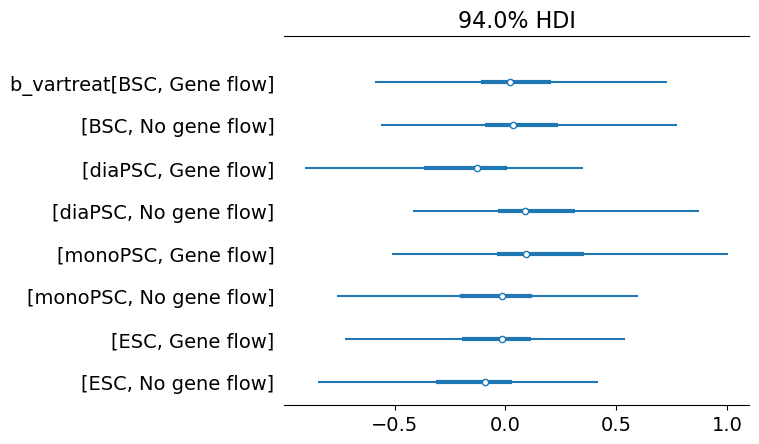

In [721]:
# check coefficients for gene flow and no gene flow

az.plot_forest(tracem7, 
               var_names = ['b_vartreat'], 
               coords = {'sc_n':['BSC','diaPSC','monoPSC','ESC'], 't_n': ['Gene flow','No gene flow']},
              combined = True)

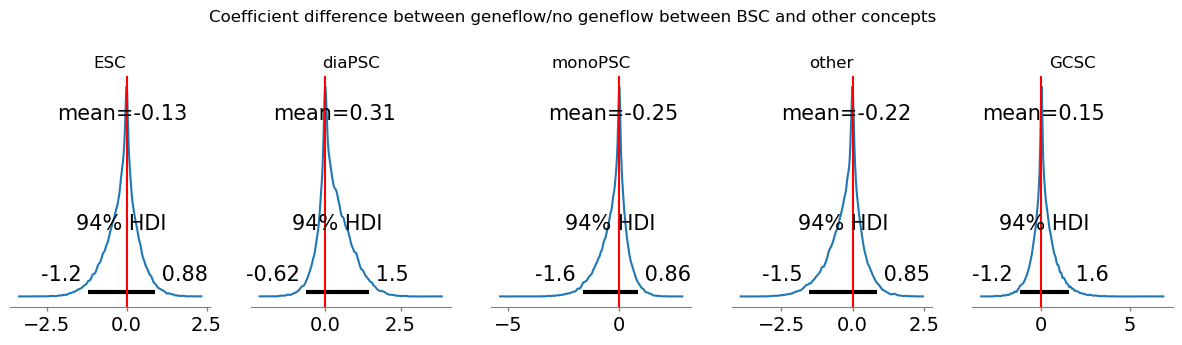

In [722]:
# check coefficient differences between BSC and the rest

fig, axs = plt.subplots(1,5, figsize = (15,3))
scss = ['ESC','diaPSC','monoPSC', 'other','GCSC']

BSC = tracem7.posterior['b_vartreat'].loc[:,:,'BSC','No gene flow'] - tracem7.posterior['b_vartreat'].loc[:,:,'BSC','Gene flow']

for ax, i in zip(axs.flat, scss):
    x = tracem7.posterior['b_vartreat'].loc[:,:,i,'No gene flow'] - tracem7.posterior['b_vartreat'].loc[:,:,i,'Gene flow']
    az.plot_posterior(x - BSC, ax=ax)
    ax.set_title(i)
    ax.axvline(0, color = 'red')
plt.suptitle('Coefficient difference between geneflow/no geneflow between BSC and other concepts',y=1.1) 
plt.show()

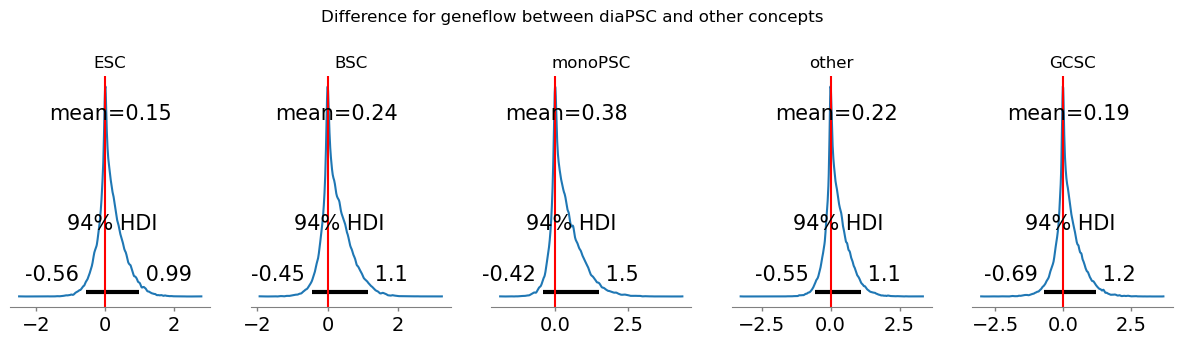

In [723]:
# check coefficient differences between diaPSC and the rest


fig, axs = plt.subplots(1,5, figsize = (15,3))


diaPSC = tracem7.posterior['b_vartreat'].loc[:,:,'diaPSC','Gene flow']
scss = ['ESC','BSC','monoPSC', 'other','GCSC']


for ax, i in zip(axs.flat, scss):
    x = tracem7.posterior['b_vartreat'].loc[:,:,i,'Gene flow']
    az.plot_posterior(x - diaPSC, ax=ax)
    ax.set_title(i)
    ax.axvline(0, color = 'red')
plt.suptitle('Difference for geneflow between diaPSC and other concepts',y=1.1) 
plt.show()

In [724]:
# ppc: new data for sc by treatment

new_sc_data = {f'sc{i}': np.repeat(i, len(df)) for i in range(6)}

ppcs_no_gene_flow = {}
ppcs_gene_flow = {}


with m7:
    for i in list(range((6))):
        pm.set_data(
            {
                "S":new_sc_data[f'sc{i}'],
                "T": np.repeat(2, len(df))
            }
        )
        ppcsc = pm.sample_posterior_predictive(tracem7, progressbar = False)
        ppcs_no_gene_flow[f'sc{i}'] = ppcsc
        
        pm.set_data(
            {
                "S":new_sc_data[f'sc{i}'],
                "T": np.repeat(0, len(df))
            }
        )
        ppcsc = pm.sample_posterior_predictive(tracem7, progressbar = False)
        ppcs_gene_flow[f'sc{i}'] = ppcsc


Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


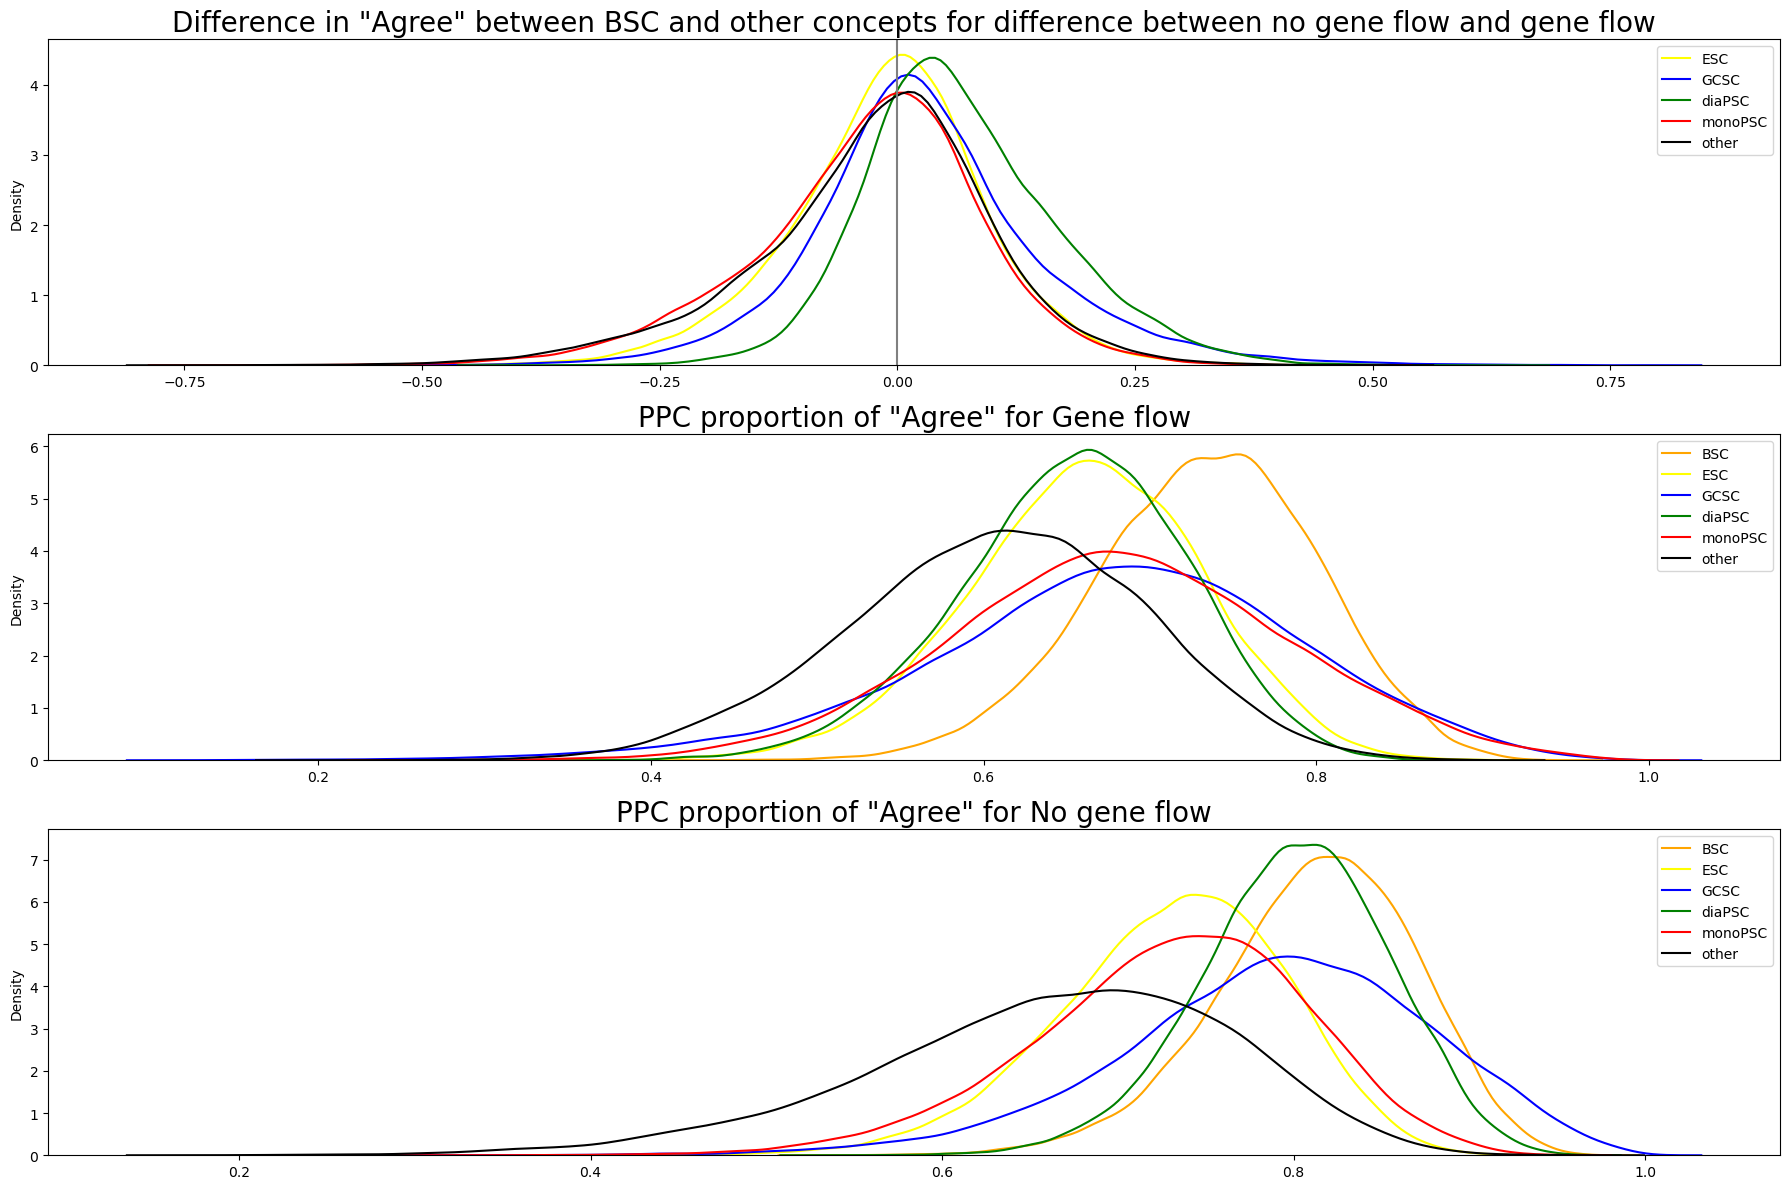

In [725]:
# plot the ppc (difference between scs for difference between treatments)
BSC_nogf = az.extract(ppcs_no_gene_flow[f'sc{0}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
BSC_gf = az.extract(ppcs_gene_flow[f'sc{0}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
BSC = BSC_nogf - BSC_gf

colors = ['orange','yellow','blue','green','red','black']

fig, ax = plt.subplots(nrows = 3, figsize = (18,12))

for i in list(range(1,6,1)):
    ngf = az.extract(ppcs_no_gene_flow[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    gf = az.extract(ppcs_gene_flow[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    SC = ngf - gf

    sns.kdeplot(np.array(SC - BSC), color = colors[i],ax=ax[0] )
    
ax[0].set_title('Difference in "Agree" between BSC and other concepts for difference between no gene flow and gene flow', fontsize = 20)
ax[0].legend(['ESC', 'GCSC', 'diaPSC', 'monoPSC', 'other'])
ax[0].axvline(0, color = 'grey')

for i in list(range(0,6,1)):
    a = az.extract(ppcs_gene_flow[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    
    sns.kdeplot(np.array(a), color = colors[i],ax=ax[1] )
    
ax[1].set_title('PPC proportion of "Agree" for Gene flow', fontsize = 20)
ax[1].legend(['BSC','ESC', 'GCSC', 'diaPSC', 'monoPSC', 'other'])

for i in list(range(0,6,1)):
    a = az.extract(ppcs_no_gene_flow[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    
    sns.kdeplot(np.array(a), color = colors[i],ax=ax[2] )
    
ax[2].set_title('PPC proportion of "Agree" for No gene flow', fontsize = 20)
ax[2].legend(['BSC','ESC', 'GCSC', 'diaPSC', 'monoPSC', 'other'])

fig.tight_layout()

## Influence treatment vs influence species concepts

In [726]:
# create new data for Treatment
new_t_data = {}

for i in range(3):
    new_t_data[f't{i}'] = np.repeat(i, len(df))

ppc = {}

# sample posterior predictive
with m7:
    for i in list(range((3))):
        pm.set_data(
            {
                "T":new_t_data[f't{i}']
            }
        )
        ppct = pm.sample_posterior_predictive(tracem7, progressbar = False)
        ppc[f't{i}'] = ppct

Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


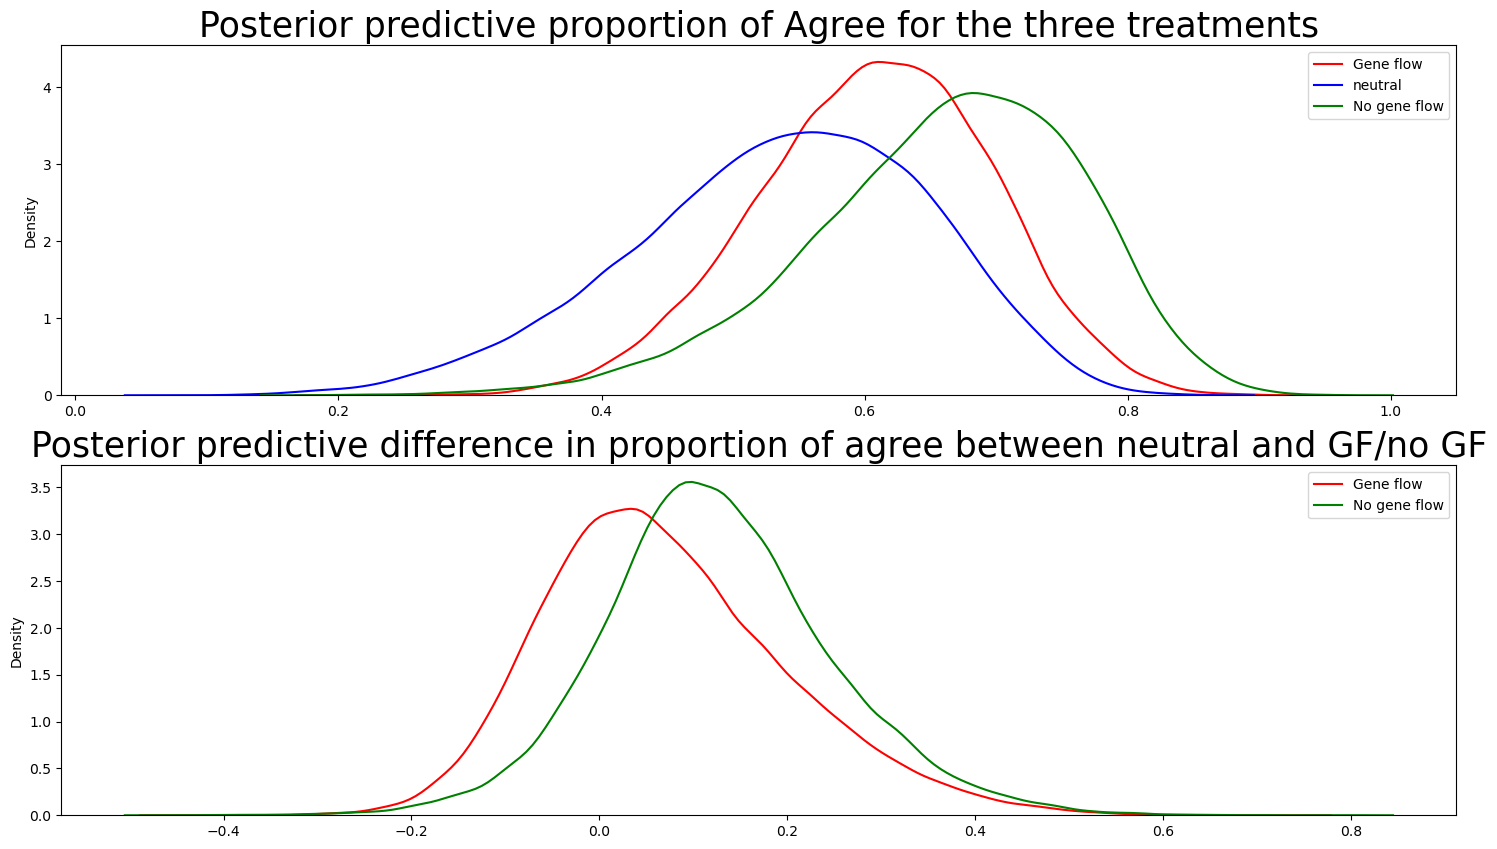

In [727]:
# plot

Neutral = az.extract(ppc[f't{1}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

colors = ['red','blue','green']

fig, ax = plt.subplots(nrows = 2, figsize = (18,10))

for i in [0,1,2]:
    a = az.extract(ppc[f't{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


    sns.kdeplot(np.array(a), color = colors[i],ax=ax[0] )
ax[0].set_title('Posterior predictive proportion of Agree for the three treatments', fontsize = 25)
ax[0].legend(['Gene flow','neutral','No gene flow'])

for i in [0,2]:
    a = az.extract(ppc[f't{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


    sns.kdeplot(np.array(a) - Neutral, color = colors[i],ax=ax[1] )
ax[1].set_title('Posterior predictive difference in proportion of agree between neutral and GF/no GF', fontsize = 25)
ax[1].legend(['Gene flow','No gene flow'])

plt.show()


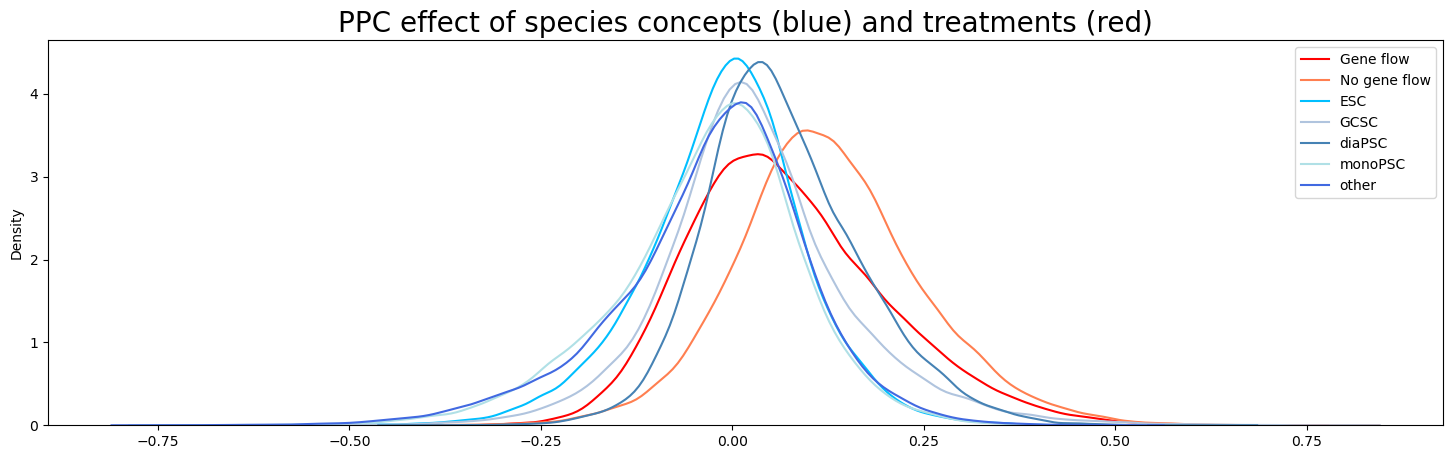

In [728]:
# compare concept effect and treatment effect
Neutral = az.extract(ppc[f't{1}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

blues = [ 'blue',
 'deepskyblue',
 'lightsteelblue',
 'steelblue',
 'powderblue',
 'royalblue',
 ]
reds= ['red','orange','coral']

fig, ax = plt.subplots(figsize = (18,5))

for i in [0,2]:
    a = az.extract(ppc[f't{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    sns.kdeplot(np.array(a) - Neutral, color = reds[i],ax=ax )
#     ax.legend(list(lst2))


for i in list(range(1,6,1)):
    ngf = az.extract(ppcs_no_gene_flow[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    gf = az.extract(ppcs_gene_flow[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    SC = ngf - gf

    sns.kdeplot(np.array(SC - BSC), color = blues[i],ax=ax )
    
ax.set_title('PPC effect of species concepts (blue) and treatments (red)', fontsize = 20)
ax.legend(['Gene flow','No gene flow','ESC', 'GCSC', 'diaPSC', 'monoPSC', 'other'])
plt.show()

## Specialization

Given our DAG, model 7 should also give us an idea of the direct (not total) causal influence of specialization.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

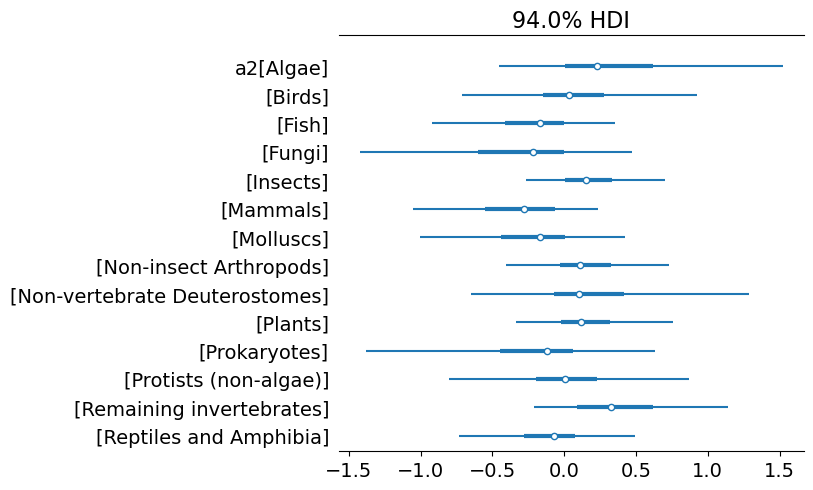

In [729]:
# coefficients

az.plot_forest(tracem7, var_names = 'a2', combined = True)

In [730]:
# create new data for Tax
new_tax_data = {}

for i in range(14):
    new_tax_data[f'tax{i}'] = np.repeat(i, len(df))

ppc_tax = {}

with m7:
    for i in range(14):
        pm.set_data(
            {
                "TA":new_tax_data[f'tax{i}']
            }
        )
        ppct = pm.sample_posterior_predictive(tracem7, progressbar = False)
        ppc_tax[f'tax{i}'] = ppct

Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


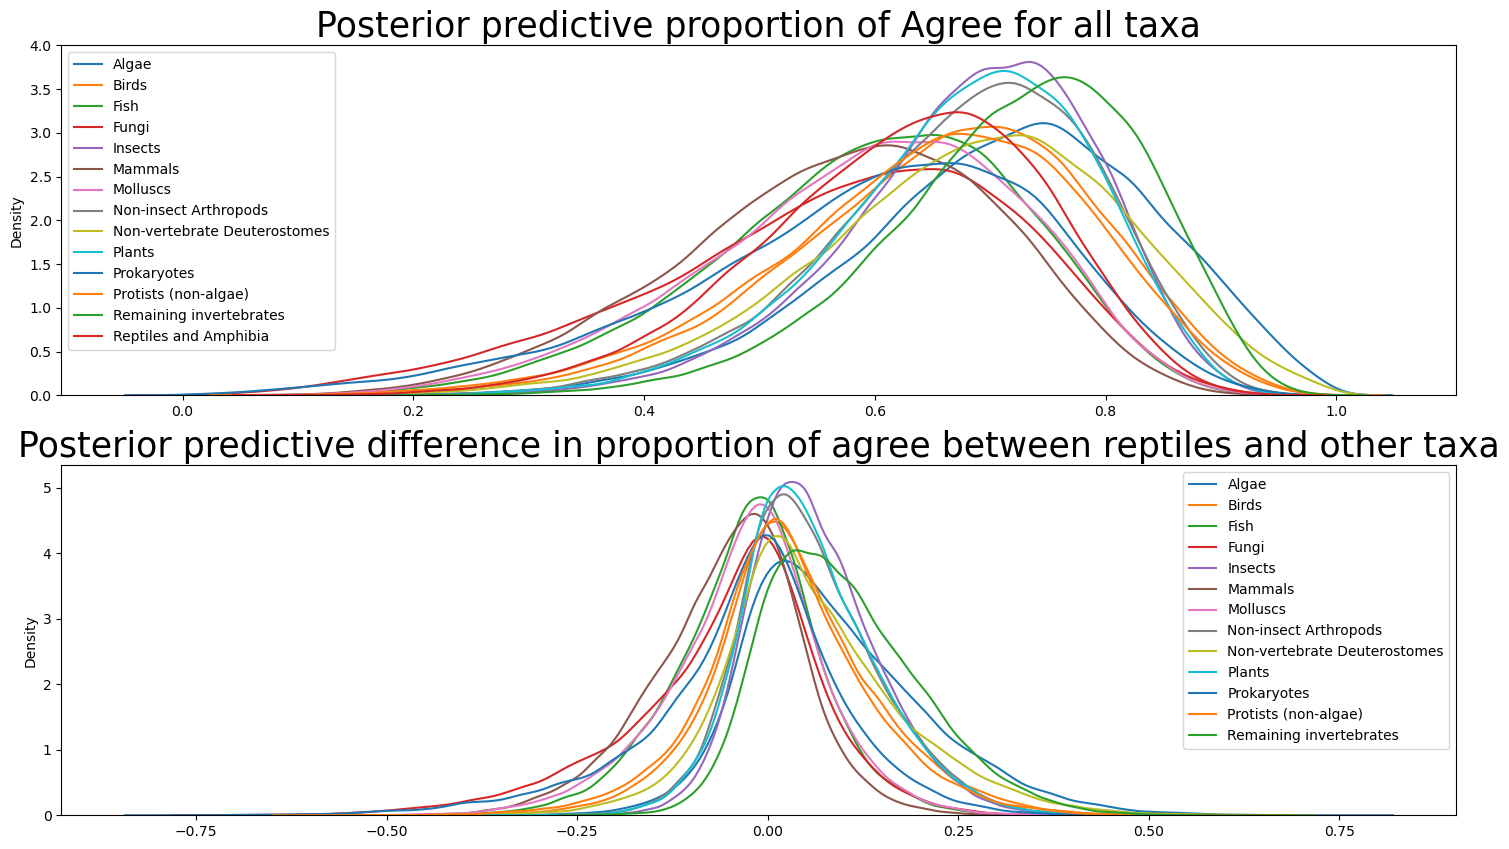

In [731]:
Reptiles = az.extract(ppc_tax[f'tax{13}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

fig, ax = plt.subplots(nrows = 2, figsize = (18,10))

for i in range(0,14,1):
    a = az.extract(ppc_tax[f'tax{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


    sns.kdeplot(np.array(a), ax=ax[0] )
    
ax[0].set_title('Posterior predictive proportion of Agree for all taxa', fontsize = 25)

for i in range(0,13):
    a = az.extract(ppc_tax[f'tax{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


    sns.kdeplot(np.array(a) - Reptiles, ax=ax[1] )
ax[1].set_title('Posterior predictive difference in proportion of agree between reptiles and other taxa', fontsize = 25)
ax[1].legend(list(tracem7.posterior['tax_n'].values)[:-1])
ax[0].legend(list(tracem7.posterior['tax_n'].values))

plt.show()
